In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.constants import G, M_earth, R_earth
from astropy import units as u
import numpy as np
import math

In [2]:

# Converts starting and ending keplarian coordinates to cartesian ones

# Need semi major axis, eccentricity, argument of periapsis, long of ascending node, inclination, mean anomaly

max_alt = 418000
min_alt = 417000


planet_radius = 6371000
planet_mass = 5.972e24
universal_grav_constant = 6.67e-11
#print(universal_grav_constant)

e = eccentricity = 0.0000271
w = argument_of_periapsis = 59.6597
omega = ascending_node_long = 206.5281
i = inclination = 51.6427
Ma = mean_anomaly = 279.2646
t = considered_epoch = 0


Apoapsis = max_alt + planet_radius
Periapsis = min_alt + planet_radius 
a = semi_major_axis = (Apoapsis + Periapsis) / 2

mu = stand_grav_param = planet_mass * universal_grav_constant
print(mu)

398332400000000.0


In [3]:
# Root finder for eccentric anomaly

def sign(x):
    if x > 0:
        return 1
    else:
        return -1

def Ecc_Anom_Function(E, M, e, in_rads):
    if in_rads == False:
        E = E * np.pi / 180
        M = M * np.pi / 180 
        return np.degrees((E - (e * np.sin(E))) - M)
    else:
        return (E - (e * np.sin(E))) - M

def Ecc_Anom_Root_Finder(E_min, E_max, tolerance, mean_anomaly, e, in_rads):
    
    iterations = 0
    E_left = E_min
    E_right = E_max
    
    while abs(E_left - E_right) > tolerance:
        iterations += 1
        E_mid = (E_left + E_right) / 2
        if sign(Ecc_Anom_Function(E_mid, mean_anomaly, e, in_rads)) == sign(Ecc_Anom_Function(E_left, mean_anomaly, e, in_rads)):
            E_left = E_mid
        else:
            E_right = E_mid
    print(iterations)
    return((E_left + E_right) / 2, Ecc_Anom_Function((E_left + E_right) / 2, mean_anomaly, e, in_rads))

19
19
19
19
19


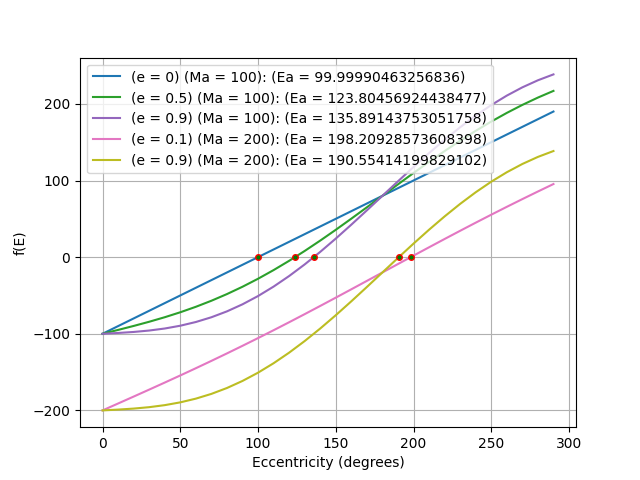

In [4]:
# A root finder visualization
quick_func = np.vectorize(Ecc_Anom_Function)


mean_anomaly_to_check = np.array([100, 100, 100, 200, 200])

#print(mean_anomaly_to_check)
ecc_to_check = [0, 0.5, 0.9, 0.1, 0.9]


axes = plt.axes()
#axes.grid(False)
axes.grid(True)
possible_Ecc = np.arange(0,300,10)

for i in range(len(ecc_to_check)):
    x, y = Ecc_Anom_Root_Finder(0, 500, 0.001, mean_anomaly_to_check[i], ecc_to_check[i], False)
    output_func = quick_func(possible_Ecc, mean_anomaly_to_check[i], ecc_to_check[i], False)
    
    axes.plot(possible_Ecc, output_func, label = f"(e = {ecc_to_check[i]}) (Ma = {mean_anomaly_to_check[i]}): (Ea = {x})")
    axes.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
axes.set_xlabel("Eccentricity (degrees)")
axes.set_ylabel("f(E)")
axes.legend()
plt.show()

In [5]:
# Compute Mean Anomaly through epochs if needed (Ma)
Ma = np.radians(Ma)
#Ma = Ma + t * math.sqrt(mu / (a ** 3))

# Compute Eccentric Anomaly from root finder (Ea)
Ea, prox = Ecc_Anom_Root_Finder(0, 500, 0.00001, Ma, e, True)

#Ea = np.radians(Ea)

# Compute distance from satellite to the centre of the body (radius, Rc)

Rc = a * (1 - e * math.cos(Ea))

# Compute True Anomaly (v)

v = 2 * np.arctan2(math.sqrt(1 + e) * math.sin((Ea) / 2), math.sqrt(1 - e) * math.cos((Ea) / 2))
print(Ea, Ma, v, Rc)

26
4.874061793088913 4.8740867542649555 4.874035046431029 6788470.386719696


In [6]:
i = np.radians(i)
w = np.radians(w)
omega = np.radians(omega)

# Orbital Reference Frame
O = Rc * np.array([math.cos(v), math.sin(v), 0])
dO = (math.sqrt(mu * a) / Rc) * np.array([(-1 * math.sin(Ea)), (math.sqrt(1 - (e ** 2)) * math.cos(Ea)), 0])
print(O)
print(dO)

[ 1092557.00228619 -6699973.83488366        0.        ]
[7560.26614554 1233.05146612    0.        ]


In [7]:
# Transformation sequence to body-centric coordinates
# Position Section
Rx = O[0] * (math.cos(w) * math.cos(omega) - math.sin(w) * math.cos(i) * math.sin(omega)) - O[1] * (math.sin(w) * math.cos(omega) * math.cos(i) * math.sin(omega))
Ry = O[0] * (math.cos(w) * math.sin(omega) + math.sin(w) * math.cos(i) * math.cos(omega)) + O[1] * (math.cos(w) * math.cos(i) * math.cos(omega) - math.sin(w) * math.sin(omega))
Rz = O[0] * (math.sin(w) * math.sin(i)) + O[1] * (math.cos(w) * math.sin(i))
R = Rx, Ry, Rz

# Velocity Section
dRx = dO[0] * (math.cos(w) * math.cos(omega) - math.sin(w) * math.cos(i) * math.sin(omega)) - dO[1] * (math.sin(w) * math.cos(omega) * math.cos(i) * math.sin(omega))
dRy = dO[0] * (math.cos(w) * math.sin(omega) + math.sin(w) * math.cos(i) * math.cos(omega)) + dO[1] * (math.cos(w) * math.cos(i) * math.cos(omega) - math.sin(w) * math.sin(omega))
dRz =  dO[0] * (math.sin(w) * math.sin(i)) + dO[1] * (math.cos(w) * math.sin(i))
dR = dRx, dRy, dRz
print(R, dR)

(2231405.2380420384, -650003.7969818856, -170308.26298131832) (-933.9747649711642, -7609.9406833814455, 498.5964515836121)


In [8]:
# Just a check for the initial velocity magnitude
print(math.sqrt((dRx ** 2 + dRy ** 2 + dRz ** 2)))

7683.235287801537


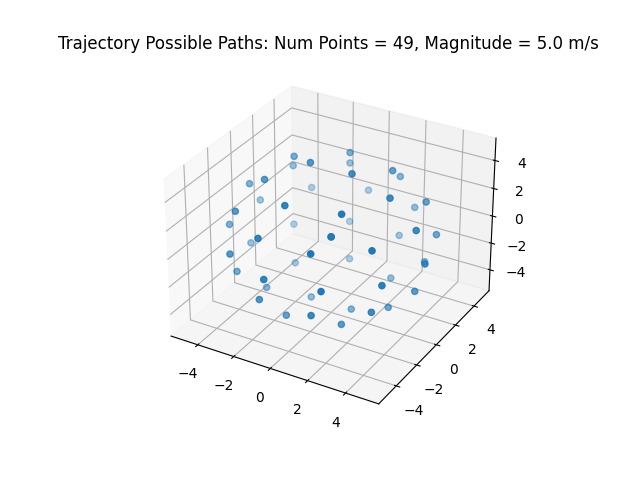

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import math as math
%matplotlib widget
N_count = 0


def create_possible_paths(magnitude, n_points):
    s_r = magnitude # Magnitude of thrust
    N_count = 0
    
    sphere_points = np.zeros((int(np.ceil(n_points)) + 2,3))
    
    sphere_area = (4 * np.pi) / n_points
    d = np.sqrt(sphere_area)    

    M_theta = int(np.ceil(np.pi/d))
    d_theta = np.pi/M_theta
    d_phi = sphere_area / d_theta
    for m in range(0, M_theta):
        theta = (np.pi * (m + 0.5)) / M_theta
        M_phi = round((2 * np.pi * np.sin(theta)) / d_phi)
        for n in range (0, M_phi):
            phi = (2 * np.pi * n) / M_phi
            sphere_points[N_count] = spherical_points_to_cartesian(s_r, theta, phi)
            N_count += 1
    plot_point_num(sphere_points, N_count)
    return(sphere_points)


def spherical_points_to_cartesian(r, theta, phi):
    """Converts spherical coordinates into cartesian ones"""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    returned_vector = r * np.array([x,y,z])
    
    return returned_vector

def plot_point_num(points, N_count):
    fig = plt.figure()
    ax_p = fig.add_subplot(projection='3d')
    ax_p.scatter(points[:,0], points[:,1], points[:,2])
    ax_p.set_title(f"Trajectory Possible Paths: Num Points = {N_count}, Magnitude = {np.linalg.norm(points[0])} m/s")



path_starts = create_possible_paths(5, 50)

6.67e-11


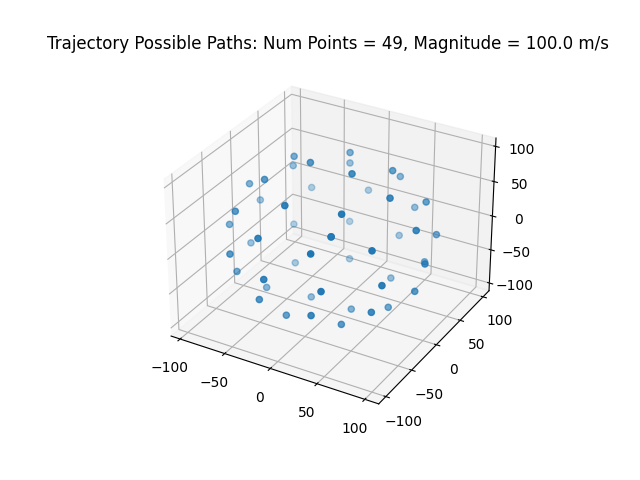

In [10]:
import numpy as np

grav_const = 6.67e-11
print(grav_const)
joe = 0
class Body():
    def __init__(self, name, y, mass):
        self.name = name
        self.y = y
        self.mass = mass
        
class Simulation(Body):
    def __init__(self, max_steps, dt, max_sims, bodies):
        self.bodies = bodies
        self.max_steps = max_steps
        self.dt = dt
        self.max_sims = max_sims

    def run_sim(self, satellite):
        
        paths = np.zeros((self.max_sims, 3, int(self.max_steps / self.dt)))
        #print(len(paths[0][0]))
        path_alterations = create_possible_paths(100, self.max_sims)
        for p in range(len(paths)):
            altered_y_i = satellite.y
            altered_y_i[3:] += path_alterations[p]
            t_list, y = RK4(self, altered_y_i, grav_function, self.max_steps, self.dt)
            paths[p] = y[:3]
            
        return paths

def grav_function(sim, y):
    """Calculates the acceleration experienced by the object"""
    
    y_new = np.zeros(6)
    for body in sim.bodies:
        #print(joe)
        sep = body.y[:3] - y[:3]
        sep_mag = np.linalg.norm(sep)

        #print(sep_mag)
        accel = ((grav_const * body.mass) / (sep_mag ** 3)) * sep
        
        #print(np.linalg.norm(accel))
        #if np.linalg.norm(accel) > 100000:
        #    print(accel, sep, body.mass)
        #print(y)
        y_new[3:] += accel * sim.dt
        #print(y_new)
        y_new[:3] += (y[3:] + y_new[3:]) * sim.dt
        #print(y_new)
    return y_new
        
        
                    
def RK4(sim, y_initial, f, t, dt):
    """Implementation of a 4th-order Runge Kutta method."""  
    m = y_initial.shape[0]
    max_steps = int(t/dt)
    tlist = np.linspace(0, t, max_steps)
    y = np.zeros((m, max_steps), float)
    y[:, 0] = y_initial
    #y[:, 0] = Sim1.sat_y
    for i in range(0,max_steps-1):
        k1 = f(sim, y[:, i])
        #print(k1)
        k2 = f(sim, y[:, i] + (0.5 * dt * k1))
        #print(k2)
        k3 = f(sim, y[:, i] + 0.5 * dt * k2)
        k4 = f(sim, y[:, i] + dt * k3)
        y[:, i + 1] = y[:, i] + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return(tlist, y)
joe = 0


Sat = Body("Satellite", np.array([22314050.238, -6.50E+04, -1.70E+04, -933.974765, -5000.940683, 498.5964516]), 2)

# 5.97e24

#Sat = Body("Satellite", np.array([-1.43e11, 1678245, 4.84E+10, -9083, -2.34, -28122]), 2)
Planet = Body("Planet", np.array([1,1,1,1,1,1]), 5.97e24)
#print(Sat.y)

Sim1 = Simulation(10000, 10, 50, [Planet])

#grav_function(Sim1, Sat.y)
#Simulation.run_sim(Sim1)

#print(Sim1.sat_y)
#t_list, y = RK4(Sim1, Sat.y, grav_function, 120000, 2000)


paths = Simulation.run_sim(Sim1, Sat)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


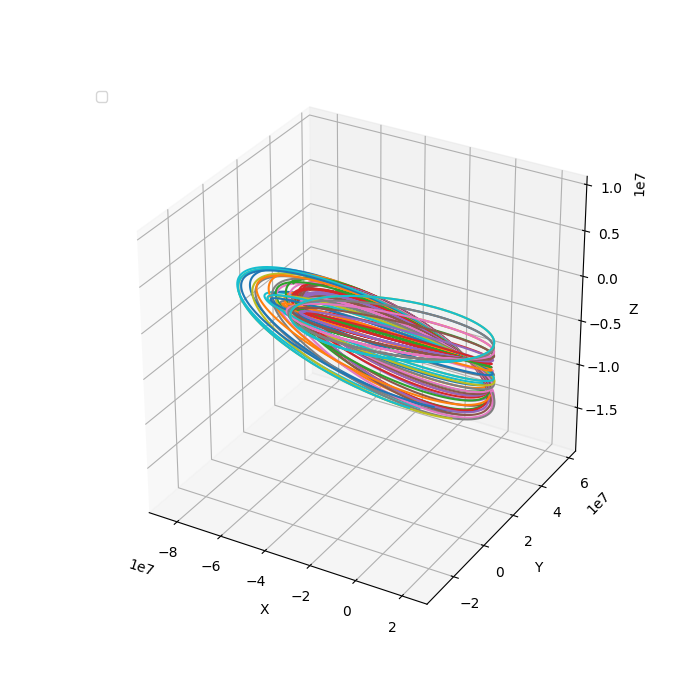

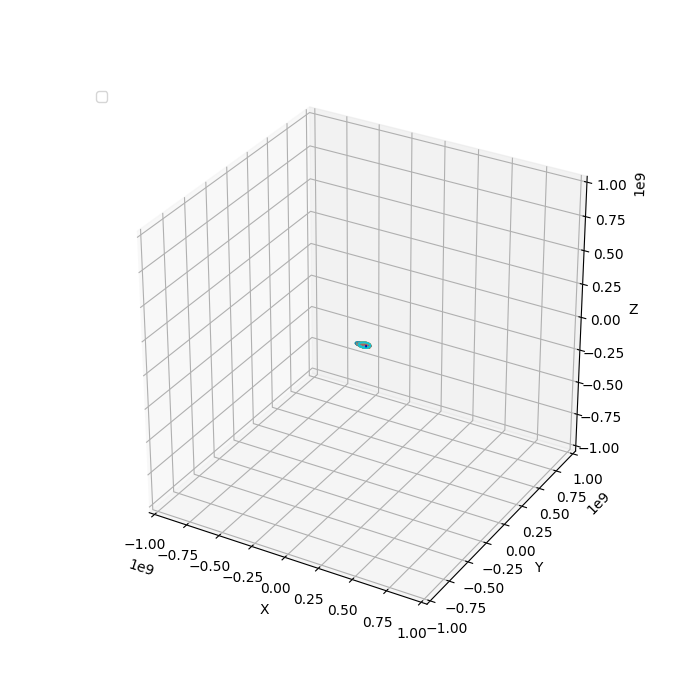

In [11]:
import matplotlib.pyplot as plt
%matplotlib widget
# Graphing section
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

graphcounter = 0

# This just names the orbital paths from the CSV
for path in paths:
    ax.plot3D(path[0], path[1], path[2])

leg = plt.legend(loc='upper left')

    
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

ax.set_xlabel('X')

ax.set_ylabel('Y')

ax.set_zlabel('Z')


plt.show()
x = 6371000 * np.outer(np.cos(u), np.sin(v))
y = 6371000 * np.outer(np.sin(u), np.sin(v))
z = 6371000 * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z, rstride=10, cstride=10, color='b')

# The area that the graph will show upon start
GraphAreaStart = 1000000000

ax.set_xlim3d(-1 * GraphAreaStart, GraphAreaStart)
ax.set_ylim3d(-1 * GraphAreaStart, GraphAreaStart)
ax.set_zlim3d(-1 * GraphAreaStart, GraphAreaStart)

plt.show()